In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from konlpy.tag import Mecab,Okt
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten

2023-07-10 02:00:26.168411: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# 데이터 불러오기
data = pd.read_csv('train.csv')
data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [3]:
# class 열을 숫자로 변환
encoder = LabelEncoder()
data['class'] = encoder.fit_transform(data['class'])

In [4]:
# konlpy의 Mecab을 이용한 토큰화
mecab = Okt()
data['conversation'] = data['conversation'].apply(mecab.morphs)
#data['conversation'] = [mecab.morphs(sentence) for sentence in data['conversation']]

In [5]:
data.head()

,idx,class,conversation
0,0,3,"[지금, 너, 스스로, 를, 죽여, 달라, 고, 애원, 하는, 것, 인가, ?, \..."
1,1,3,"[길동, 경찰서, 입니다, ., \n, 9시, 40분, 마트, 에, 폭발물, 을, ..."
2,2,1,"[너, 되게, 귀여운거, 알, 지, ?, 나, 보다, 작은, 남자, 는, 첨, 봤어..."
3,3,0,"[어이, 거기, \n, 예, ??, \n, 너, 말, 이야, 너, ., 이리, 오라..."
4,4,0,"[저기, 요, 혹시, 날, 이, 너무, 뜨겁잖아요, ?, 저희, 회사, 에서, 이,..."


In [6]:
# 케라스를 이용한 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['conversation'])
sequences = tokenizer.texts_to_sequences(data['conversation'])

In [7]:
# 입력 데이터 패딩 처리 
#data_pad = pad_sequences(sequences)   #hjnam

#hjnam
word_index = tokenizer.word_index
index_word = {idx: word for word, idx in word_index.items()}
data_pad = [[index_word[idx] for idx in seq if idx != 0] for seq in sequences]

In [8]:
print(data_pad[0])

['지금', '너', '스스로', '를', '죽여', '달라', '고', '애원', '하는', '것', '인가', '?', '\n ', '아닙니다', '.', '죄송합니다', '.', '\n ', '죽', '을', '거', '면', '혼자', '죽지', '우리', '까지', '사건', '에', '휘', '말리', '게', '해', '?', '진짜', '죽여', '버리고', '싶게', '.', '\n ', '정말', '잘', '못', '했습니다', '.', '\n ', '너', '가', '선택', '해', '.', '너', '가', '죽을래', '네', '가족', '을', '죽여줄까', '.', '\n ', '죄송합니다', '.', '정말', '잘', '못', '했습니다', '.', '\n ', '너', '에게는', '선택', '권', '이', '없어', '.', '선택', '못', '한다면', '너', '와', '네', '가족', '까지', '모조리', '죽여', '버릴거야', '.', '\n ', '선택', '못', '하겠습니다', '.', '한번', '만', '도와주세요', '.', '\n ', '그냥', '다', '죽여', '버려야겠군', '.', '이의', '없지', '?', '\n ', '제발', '도와주세요', '.']


In [9]:
#hjnam
from gensim.models import Word2Vec

# Set the size of the word vectors
vector_size = 100
model_w2v = Word2Vec(sentences=data_pad, vector_size=vector_size, window=5, min_count=3, sg=0)
#model_w2v.wv.save_word2vec_format('/home/aiffel/aiffel/DLthon/AiffelDLTon/DNN_BASELINE/data') 

embedding_dim = model_w2v.vector_size


In [10]:
#hjnam
data_embeddings = []

for tokens in data_pad:
    sample_vectors = []
    
    for token in tokens:
        if token in model_w2v.wv:
            word_vector = model_w2v.wv.get_vector(token)
            sample_vectors.append(word_vector)
    
    # Add the sample vectors to the list of embeddings
    data_embeddings.append(sample_vectors)

# Pad the sequences of word vectors to have the same length
max_length = max(len(sample) for sample in data_embeddings)
data_embeddings = pad_sequences(data_embeddings, maxlen=max_length, dtype='float32')

# 데이터셋 분리
X_train, X_val, y_train, y_val = train_test_split(data_embeddings, data['class'], test_size=0.2, random_state=42)


In [11]:
#hjnam
model_result = model_w2v.wv.most_similar("돈")
#model_result = model_w2v.wv.most_similar("파견")
print(model_result)

[('없어', 0.8070448637008667), ('빌려주라', 0.8055912256240845), ('지갑', 0.7998784780502319), ('뒤져서', 0.7956092953681946), ('빌려줘', 0.7869136333465576), ('영지', 0.7763493657112122), ('없는데', 0.775225818157196), ('빌려줘라', 0.772748589515686), ('내놔', 0.7658608555793762), ('나오면', 0.7645431160926819)]


In [12]:
def get_mlp():
    # MLP 모델 생성
    model = Sequential()
    #model.add(Embedding(len(tokenizer.word_index)+1, 128, input_length=data_pad.shape[1]))
    #model.add(Embedding(len(tokenizer.word_index)+1, 128, input_length=len(data_pad)))  #hjnam
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(len(data['class'].unique()), activation='softmax'))
    return model

In [13]:
max_length, embedding_dim

(332, 100)

In [14]:
model = get_mlp()
model.build(input_shape=(None, max_length, embedding_dim))  #hjnam
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 33200)             0         
                                                                 
 dense (Dense)               (None, 64)                2124864   
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 2,125,124
Trainable params: 2,125,124
Non-trainable params: 0
_________________________________________________________________


2023-07-10 02:00:58.277024: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [15]:
from keras.layers import Conv1D, GlobalMaxPooling1D

def get_cnn():
    # CNN 모델 생성
    model = Sequential()
    #model.add(Embedding(len(tokenizer.word_index)+1, 128, input_length=data_pad.shape[1]))
    #model.add(Embedding(len(tokenizer.word_index)+1, 128, input_length=len(data_pad))) #hjnam
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(len(data['class'].unique()), activation='softmax'))

    return model


In [16]:
model = get_cnn()
model.build(input_shape=(None, max_length, embedding_dim))  #hjnam
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 328, 128)          64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 72,644
Trainable params: 72,644
Non-trainable params: 0
_________________________________________________________________


In [17]:
from keras.layers import LSTM, Dropout
from keras.layers import Input, Reshape

def get_lstm():
    # LSTM 모델 생성
    model = Sequential()
    #model.add(Embedding(len(tokenizer.word_index)+1, 128, input_length=data_pad.shape[1]))
    #model.add(Embedding(len(tokenizer.word_index)+1, 128, input_length=tokenized.shape[1]))
    #model.add(Input(shape=(len(tokenizer.word_index)+1, vector_size)))
    #model.add(Input(shape=(vector_size))) #hjnam
    #model.add(Reshape((1, vector_size))) #hjnam
    #model.add(Reshape((vector_size))) #hjnam
    model.add(LSTM(64))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(len(data['class'].unique()), activation='softmax'))

    return model


In [18]:
model = get_lstm()
model.build(input_shape=(None, max_length, embedding_dim))  #hjnam
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 4)                 260       
                                                                 
Total params: 46,660
Trainable params: 46,660
Non-trainable params: 0
_________________________________________________________________


2023-07-10 02:00:58.544207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-10 02:00:58.545134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-10 02:00:58.545862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [19]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
len(X_train), len(y_train)

(3160, 3160)

In [21]:
# 모델 학습
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30)

Epoch 1/30


2023-07-10 02:00:58.948038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-10 02:00:58.949163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-10 02:00:58.949990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

99/99 [==============================] - ETA: 0s - loss: 1.1864 - accuracy: 0.4573

2023-07-10 02:01:14.546843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-10 02:01:14.547914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-10 02:01:14.548763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

99/99 [==============================] - 17s 157ms/step - loss: 1.1864 - accuracy: 0.4573 - val_loss: 1.0525 - val_accuracy: 0.5342
Epoch 2/30
99/99 [==============================] - 17s 170ms/step - loss: 0.9829 - accuracy: 0.5927 - val_loss: 0.8870 - val_accuracy: 0.6684
Epoch 3/30
99/99 [==============================] - 17s 171ms/step - loss: 0.9047 - accuracy: 0.6544 - val_loss: 0.8874 - val_accuracy: 0.6582
Epoch 4/30
99/99 [==============================] - 17s 175ms/step - loss: 0.8359 - accuracy: 0.6807 - val_loss: 0.8534 - val_accuracy: 0.6633
Epoch 5/30
99/99 [==============================] - 18s 184ms/step - loss: 0.7769 - accuracy: 0.7139 - val_loss: 0.7613 - val_accuracy: 0.7203
Epoch 6/30
99/99 [==============================] - 18s 181ms/step - loss: 0.7146 - accuracy: 0.7329 - val_loss: 0.7527 - val_accuracy: 0.7165
Epoch 7/30
99/99 [==============================] - 17s 169ms/step - loss: 0.7168 - accuracy: 0.7361 - val_loss: 0.7332 - val_accuracy: 0.7190
Epoch 8/30

In [22]:
def train(get_model):
    model = get_model()
    model.summary()
    # 모델 컴파일
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # 모델 학습
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)
    return model, history

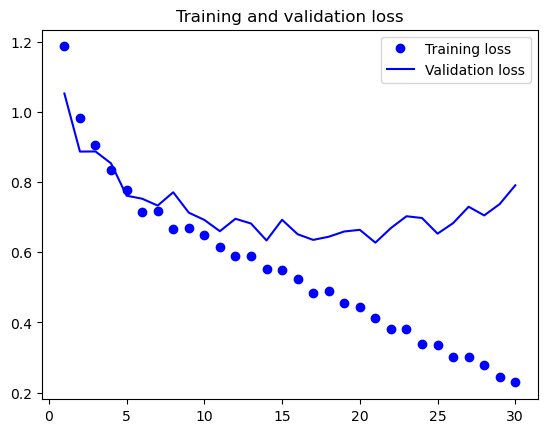

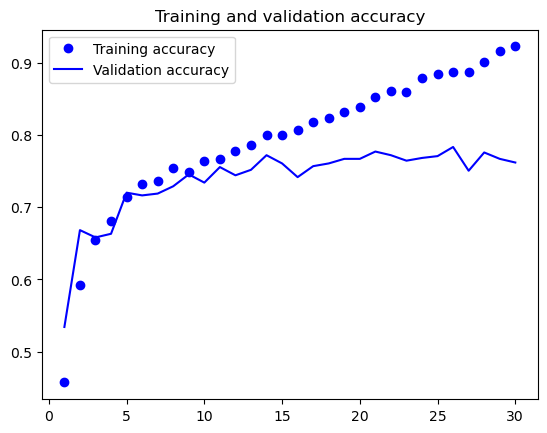

In [23]:
import matplotlib.pyplot as plt

def visualization(history):
    # 시각화를 위한 데이터 정의
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(1, len(loss) + 1)

    # 손실값 시각화
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

    # 정확도 시각화
    plt.figure()
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.show()

visualization(history)


In [24]:
#hjnam : remove '파견'
test_x = '''우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때?
네? 제가요?
그렇지? 2달만 파견 잘 갔다오면 승진이야. 
네? 저는 별로 가고 싶지 않습니다.
여기 있는 모든사람도 가기 싫어해. 그러니까 막내인 영지씨가 가는게 맞지
정말 죄송합니다. 저는 못갑니다.
장난해? 모두를 위해 영지씨가 희생하는게 싫어?
네. 부당한 방법으로 가는 것 같습니다.
영지씨 안가면 회사생활 오래 못할 것 같은데 그래도 안갈거야? 안가면 지옥일텐데.
그래도 이 방법은 아닌 것 같습니다. 죄송합니다.'''

test_y = encoder.transform(["직장 내 괴롭힘 대화"])

In [25]:
test_data = {
    "class": [test_y, ],
    "conversation": [test_x, ],
}

df2 = pd.DataFrame(test_data, index=[0])

In [26]:
#hjnam
df2['conversation'] = df2['conversation'].apply(mecab.morphs)
test_sequences = tokenizer.texts_to_sequences(df2['conversation'])
test_pad = [[index_word[idx] for idx in seq if idx != 0] for seq in test_sequences] #hjnam

In [27]:
#hjnam
word_vectors = [[model_w2v.wv.get_vector(word) for word in sentence] for sentence in test_pad]
model_w2v.wv.get_vector('싫어해')
#model_w2v.wv.get_vector('파견')

array([-0.0293376 ,  0.07141731, -0.0044572 ,  0.02494397,  0.03077496,
       -0.08763732,  0.025018  ,  0.10608406, -0.09689609, -0.03717839,
       -0.05081574, -0.076951  , -0.00989887,  0.00848044,  0.04032039,
       -0.03767918,  0.02685465, -0.04658199, -0.004305  , -0.11402662,
        0.03699422,  0.0313694 ,  0.02237909, -0.0542897 , -0.01454615,
        0.02876169, -0.0207318 ,  0.01857683, -0.04601659, -0.0130894 ,
        0.06374156,  0.02658051,  0.00654079,  0.00067168, -0.03047108,
        0.02720789,  0.02070219, -0.02732652,  0.02913838, -0.07434026,
        0.00303907, -0.04214846,  0.04520433, -0.02700432,  0.00398724,
       -0.06910831, -0.06054713, -0.03203749,  0.05647514,  0.0133449 ,
        0.01866081, -0.02027332, -0.0160547 , -0.03979237, -0.01811898,
       -0.00547834,  0.01801995,  0.04633364, -0.05109492,  0.00193684,
        0.03821616, -0.00998396, -0.02287946,  0.03183334, -0.02454902,
        0.05780311,  0.01655515,  0.045226  , -0.06944229,  0.05

In [28]:
# 예측 수행
#predictions = model.predict(test_pad)
#hjnam
word_vectors = np.array(word_vectors)
predictions = model.predict(word_vectors)


2023-07-10 02:09:46.974363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-10 02:09:46.975484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-10 02:09:46.976414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 645ms/step


2023-07-10 02:09:47.239503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-10 02:09:47.240535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-10 02:09:47.241391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [29]:
predicted_classes = np.argmax(predictions, axis=1)

In [30]:
predicted_labels = encoder.inverse_transform(predicted_classes)

In [31]:
predicted_labels

array(['직장 내 괴롭힘 대화'], dtype=object)

In [32]:
def test_routine(model):
    #predictions = model.predict(test_pad)
    predictions = model.predict(word_vectors)  #hjnam
    predicted_classes = np.argmax(predictions, axis=1)
    predicted_labels = encoder.inverse_transform(predicted_classes)
    print(predicted_labels)

In [33]:
def one_shot(get_model):
    model, history = train(get_model)
    visualization(history)
    test_routine(model)

In [34]:
one_shot(get_cnn)

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [ ]:
one_shot(get_mlp)